# Problem presentation

## Introduction

List of relevant associations of 1 July 1901 on the association contract submitted for the 2013 budget year one or more grant applications from the City or Department of Paris.

The grant applications submitted by non-associative organizations (SCOP, SCIC, scientific cooperation foundation, semi-public companies, public institutions, etc.) are not tracked. The financial aid allocated to the lines, the contributions, the contributions, the contributions, the contributions, the contributions, etc. are not also traced.

## Business problem overview

The issue here is to predict wheteher some organization will recieve a grant from the Paris municiplaity.
In fact, studying heavy and often complex dossiers is time consuming for the public agents. Moreover, it may quickly become a repetitve task.

So, automatizing the analysis would save taxpayer euros. And since there are more than 35000 municipalities in France, the yet green market seems of reasonable size.

## Prediction Task

Using the title of the project, information about the budget and the name of organization, we would to see if there are some patterns in the municiplaity's operating mode

## Prediction Use

If a pattern is confirmed, we could automatize the treatment of grant dossiers 

## Data

In order to develop a classifier that predict and better understand wheter the municipality would grant him a loan or not we need to collect many data about how many loans that were granted and in which place for example, also the amount of the loan.

In fact, all of these informations are publicly available through the Open Data Paris but the real challenging thing is how to transform this data into a something meaningful.

## Description of our dataset

The original dataset can be found from this link: 
https://opendata.paris.fr/explore/dataset/subventions-accordees-et-refusees/information/
The data we use for the challenge is also available in the directory "data" of our github repository: 
https://github.com/mkobbi/grant.git

Available features:
*   No. SIRET : SIRET number as declared by the association
*   Address : Address of the registered office as stated in the SIMPA application on the basis of a receipt in the prefecture or a publication in the Official Journal of the French Republic
*   ZIP code : Postal code of the head office
*   City : Ville du siège social
*   Title of the request : Title of the project (s) submitted in favor of which a grant is requested
*   Call for projects : Whether or not the request is part of a call for projects
*   Call for Projects Policy City : Whether or not the request relates to a call for projects under City policy (co-managed with the State)
*   Amount requested : Amount requested by the partner
*   Funded / Unfinanced : Status of the request for a grant
*   Amount voted by request : Amount granted by the City or the Department of Paris, knowing that in some cases, the Parisian community has pooled several projects and granted a lump sum subsidy that has been assigned to order to one of the projects because it can not detail the grant on each project specific.
*   Total voted in 2013 : Amount voted for the request on the referenced fiscal year. This amount may be different from the "amount voted per request" if the application is funded over several years. These cases are rare.
*   Operation : Decomposition of 2013 voted amount by nature of grant (Operating / Project Grants / Capital Grants / Unspecified Grants)
*   Project Grants : Decomposition of 2013 voted amount by nature of grant (Operating / Project Grants / Capital Grants / Unspecified Grants)
*   Equipment subsidies : Decomposition of 2013 voted amount by nature of grant (Operating / Project Grants / Capital Grants / Unspecified Grants)
*   Subsidies without specified nature : Decomposition of 2013 voted amount by nature of grant (Operating / Project Grants / Capital Grants / Unspecified Grants)
*   S-PR-SIMPA number : Request reference - internal identifier
*   Year : Year of taking into account the request

## Metric definition

We have used the precision as a metric because in our case the distribution of classes is balanced (approximatively 50% per class), our choice was to use accuracy since that the two classes are balanced.
We could also use Receiver Operating Characteristic (ROC) metric to see how good the algorithm handle unseen data.

### Confusion Matrix

A clean and unambiguous way to present the prediction results of a classifier is to use a confusion matrix (also called a contingency table).

For a binary classification problem the table has 2 rows and 2 columns. Across the top is the observed class labels and down the side are the predicted class labels. Each cell contains the number of predictions made by the classifier that fall into that cell.

![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2014/03/truth_table.png)

### Accuracy metric

In order to compute accuracy we are going to sum all true positives and all true negatives and divide this sum by the total number of individuals.

# Code

## Requirements

In [4]:
from __future__ import unicode_literals
import pandas as pd
import numpy as np
import nltk
import os
from pathlib import Path
%matplotlib inline

In [2]:
nltk.download("popular", quiet=True)

True

## Exploratory data analysis

### Loading the data

In [9]:
train_filename = Path('data/train.csv')
test_filename = Path('data/test.csv')
if train_filename.is_file() and test_filename.is_file():
    train = pd.read_csv(train_filename, sep=';')#, encoding='utf-8')
    test = pd.read_csv(test_filename, sep=';')#, encoding='utf-8')
else:
    %run train_test_generator.py    
frames = [train, test]
data = pd.concat(frames, axis=0)

### Feature description

The dataset contains 26000+ instances mostly numericals and one categorical feature.

In [62]:
data.count()

Unnamed: 0                         26
Anne                               26
Nom du partenaire                  26
Intitul de la demande              26
Appel  projets                     26
Montant vot par demande            18
Fonctionnement                     14
Subventions sur projet              4
Subventions d'quipement             0
Subventions sans nature spcifie     1
Siret                              26
CP-Adresse-Libell voie             26
CP-Adresse-Code postal             26
CP-Adresse-Ville                   26
Appel  projets PolVille            26
S-DE-Montant demand                26
N SIMPA                            26
y                                  26
dtype: int64

In [63]:
data.dtypes

Unnamed: 0                           int64
Anne                                 int64
Nom du partenaire                   object
Intitul de la demande               object
Appel  projets                      object
Montant vot par demande            float64
Fonctionnement                     float64
Subventions sur projet             float64
Subventions d'quipement            float64
Subventions sans nature spcifie    float64
Siret                                int64
CP-Adresse-Libell voie              object
CP-Adresse-Code postal             float64
CP-Adresse-Ville                    object
Appel  projets PolVille             object
S-DE-Montant demand                float64
N SIMPA                            float64
y                                    int64
dtype: object

### Visulazing the distribution of categorical variables

#### Appel   projets distribution

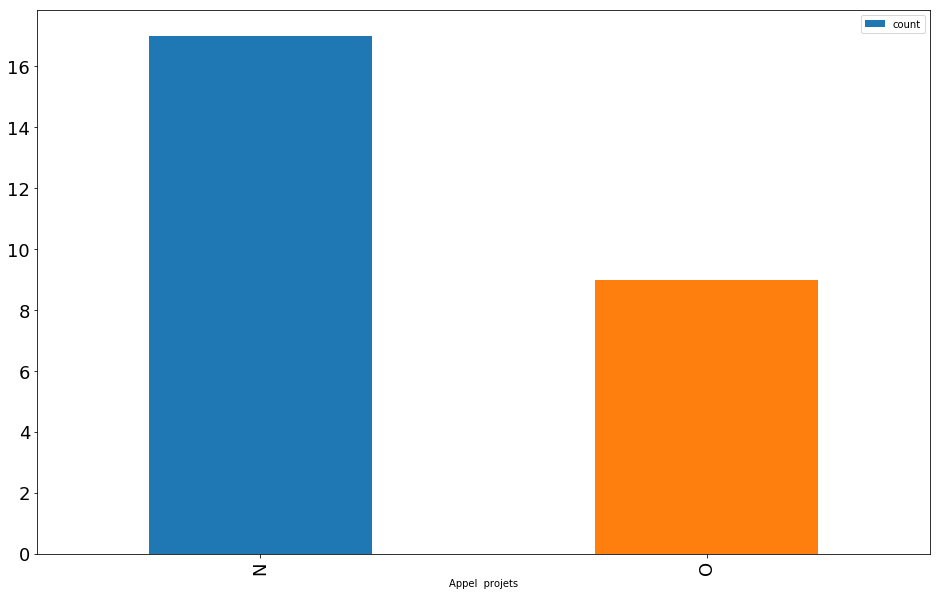

In [64]:
data.groupby('Appel  projets').count()[['CP-Adresse-Code postal']].sort_values(
    'CP-Adresse-Code postal', ascending=False).reset_index().rename(
    columns={'CP-Adresse-Code postal': 'count'}).plot.bar(
    x='Appel  projets', y='count', figsize=(16, 10), fontsize=18);

#### Appel  projets PolVille distribution (yes=1 or non=0)

In [29]:
data.groupby('Appel  projets PolVille').count()[['CP-Adresse-Code postal']].sort_values(
    'CP-Adresse-Code postal', ascending=False).reset_index().rename(
    columns={'CP-Adresse-Code postal': 'count'}).plot.bar(
    x='Appel  projets PolVille', y='count', figsize=(16, 10), fontsize=18);

#### Adresse code postal distribution

17


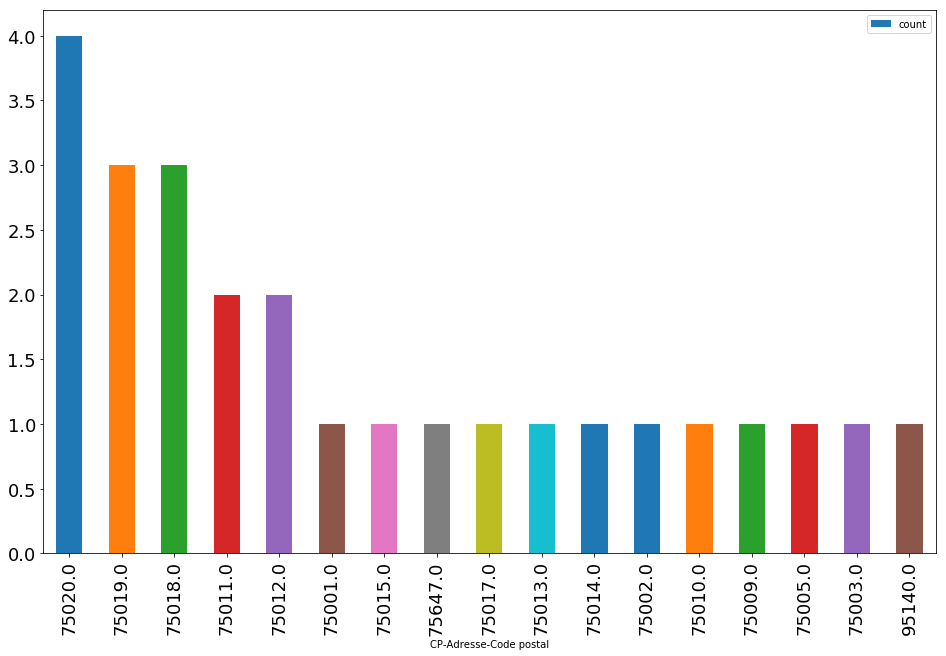

In [65]:
print(len(np.unique(data['CP-Adresse-Code postal'])))
data.groupby('CP-Adresse-Code postal').count()[['Nom du partenaire']].sort_values(
    'Nom du partenaire', ascending=False).reset_index().rename(
    columns={'Nom du partenaire': 'count'}).reset_index().loc[:50].plot.bar(
    x='CP-Adresse-Code postal', y='count', figsize=(16, 10), fontsize=18);

## Scripts


### Feature extractor

In [4]:
%%file submissions/starting_kit/feature_extractor.py
# -*- coding: utf-8 -*-

from __future__ import unicode_literals

import string
import unicodedata
import urllib
from sklearn.preprocessing import normalize
import scipy
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer


def stopword_loader(
        url="https://raw.githubusercontent.com/mkobbi/subvention-status-datacamp/master/data/stopwords-filter-fr.txt"):
    try:
        stopwords = str(urllib.urlopen(url).read().decode("utf-8").lower())
        stopwords = set(stopwords.split('\n'))
        return stopwords
    except IOError:
        print('Failed to open "%s".', url)


def document_preprocessor(doc):
    """ A custom document preprocessor

    This function can be edited to add some additional
    transformation on the documents prior to tokenization.

    """
    try:
        doc = unicode(doc, 'utf-8')
    except NameError:  # unicode is a default on python 3
        pass
    doc = unicodedata.normalize('NFKD', doc)
    doc = doc.encode('ascii', 'ignore')
    doc = doc.decode("utf-8")
    return str(doc).lower()


# def generate_tokens


def token_processor(sentence):
    """ A custom token processor

    This function can be edited to add some additional
    transformation on the extracted tokens (e.g. stemming)

    At present, this function just passes the tokens through.
    """
    stopwords = stopword_loader()
    punctuation = set(string.punctuation)
    punctuation.update(["``", "`", "..."])
    stemmer = nltk.stem.snowball.FrenchStemmer()
    stemmed_tokens = list((filter(lambda x: x not in stopwords and x not in punctuation,
                                  [stemmer.stem(t)
                                   for t in nltk.word_tokenize(sentence, 'french', False)
                                   if t.isalpha()])))
    for t in stemmed_tokens:
        yield t


def cleanDataset(data):
    fr_stopwords_url = "https://raw.githubusercontent.com/mkobbi/subvention-status-datacamp/master/data/stopwords-filter-fr.txt"
    string_columns = ['Nom du partenaire']  # ["Intitul de la demande"]
    to_drop_columns = ["Anne", "Siret", "N SIMPA", 'CP-Adresse-Libell voie', "CP-Adresse-Ville"]
    str_categorical_columns = ["Nom du partenaire", "Appel  projets", "Appel  projets PolVille"]
    num_categorical_columns = ["Anne", "CP-Adresse-Code postal"]
    num_categorical_columns = ["CP-Adresse-Code postal"]
    data = data.fillna(value=0, axis='columns')
    data[string_columns] = data[string_columns].apply(
        lambda x: x.str.upper().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
    data[str_categorical_columns] = data[str_categorical_columns].apply(lambda x: x.astype('category').cat.codes)
    data[num_categorical_columns] = data[num_categorical_columns].apply(
        lambda x: x.astype('int'))  # .astype('category'))
    fr_stopwords = urllib.urlopen(fr_stopwords_url).read().decode("utf-8").upper()
    fr_stopwords = fr_stopwords.split('\n')
    # y = np.ravel(pd.DataFrame([data['Total vot'] > 0.0]).astype(int))
    # y = np.ravel(data.pop('y').values)
    data = data.drop(to_drop_columns, axis='columns')
    return data


class FeatureExtractor(TfidfVectorizer):
    """Convert a collection of raw docs to a matrix of TF-IDF features. """

    def __init__(self):
        # see ``TfidfVectorizer`` documentation for other feature
        # extraction parameters.
        super(FeatureExtractor, self).__init__(strip_accents='unicode',
                                               stop_words=stopword_loader(), analyzer='word')

    def fit(self, X_df, y=None):
        """Learn a vocabulary dictionary of all tokens in the raw documents.

        Parameters
        ----------
        X_df : pandas.DataFrame
            a DataFrame, where the text data is stored in the ``Intitul de la demande``
            column.
        """
        X_df = cleanDataset(X_df)
        super(FeatureExtractor, self).fit(X_df)
        return self

    def fit_transform(self, X_df, y=None):
        self.fit(X_df)
        return self.transform(X_df)

    def transform(self, X_df):
        # print "transform X_df="
        # print X_df
        # print "transform new="
        X_df = cleanDataset(X_df)
        words = super(FeatureExtractor, self).transform(X_df['Intitul de la demande'])

        X_df = X_df.drop(['Intitul de la demande'], axis='columns')
        data_sparse = scipy.sparse.csr_matrix(X_df.values[:, 1:])
        X = normalize(scipy.sparse.hstack((data_sparse, words)))
        return X

    def build_tokenizer(self):
        """
        Internal function, needed to plug-in the token processor, cf.
        http://scikit-learn.org/stable/modules/feature_extraction.html#customizing-the-vectorizer-classes
        """
        tokenize = super(FeatureExtractor, self).build_tokenizer()
        return lambda doc: token_processor(doc)


['Unnamed: 0', 'Anne', 'Nom du partenaire', 'Intitul de la demande', 'Appel  projets', 'Montant vot par demande', 'Fonctionnement', 'Subventions sur projet', "Subventions d'quipement", 'Subventions sans nature spcifie', 'Siret', 'CP-Adresse-Libell voie', 'CP-Adresse-Code postal', 'CP-Adresse-Ville', 'Appel  projets PolVille', 'S-DE-Montant demand', 'N SIMPA', 'y']


TypeError: no supported conversion for types: (dtype('O'),)

### Classifier

In [ ]:
%%file submissions/starting_kit/classifier.py
# -*- coding: utf-8 -*-
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier


class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = RandomForestClassifier(n_jobs=-1)

    def fit(self, X, y):
        self.clf.fit(X.todense(), y)

    def predict(self, X):
        return self.clf.predict(X.todense())

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [6]:
!ramp_test_submission --quick-test

1